**Final Project**

CIS 545: Big Data Analyics

Group Members:
  * Mostafa Ismail
  * Henry Sanchez
  * Ifrah Ahmed

# **Deep Learning for Medical Image Segmentation**




## Outline

The project **Deep Learning for Medical Image Segmentation** notebook is split into:

  * Introduction 
  * Data:
    * Code Imports      
    * Visualize a 3D CT Image
    * Initial data exploration
  * Data Preprocessing:
    * Simplify subject ID
    * Create train and test folders
    * Create Custom Dataset
    * Load files, Transform and Dataloader
    * Visualize the images
  * Machine Learning
    * Train and Test Functions
    * Model 1: simple FCNN
      * Create the model
      * Train
      * Test
    * Model 2: U-Net
      * Create the model
      * Train
      * Test
    * Model 3: FCN-ResNet101
      * Create the model
      * Train
      * Test
    * ROC and Model Comparison
      * ROC functions
      * ROC comparison
  * Test Run on actual 3D CT Image
  * Limitations of current approach
  * Conclusion
  * References

## Introduction

Medical Image analysis is a very interesting topic and currently there are a lot of research in this area. Image segmentation is specially ineteresting because it showes clinical information like the weight or volume of an object inside our bodies. It has been shown the lung weight can be used as a measure for Pulmonary Edema, excess fluid in the lung, which makes it very difficult to breath. It's also an indication for heart problems. The amoung of air in each lung is also an inportant measure of lung functionality. All of these measures are made possible by accurate lung segmentation. 

Here in this project, we try to understand the distribution of the pixels intensities of the lungs from CT scans and try to train a model to automatically segment the lung region. We used simple fully connected neural netwrok (fcnn), U-Net, and Resnet. 

An extension for this project is to accuratly segment the airways, the vasculatures, or the injured lung. The hardest part is to first manually segment these regions to get the training dataset. In this project, we only have the dataset with whole lung region segmentation.


We worked on lung segmentation from CT images. We have 18 3D images and their masks, each one has around 500 coronal slices, thats around 9000 images and 9000 masks. These images are saved in a nifti file format. We used nibabel library to load these kind of images. First, we noticed that the patients have long subject IDs. We ecoded them in a dictionary with simpler new IDs, 0 to 18. Each new 2D slice is saved as patientID_sliceNumber.png/tiff. The masks are 8 bit unsinged numbers with ones and zeros, and so are saved in a png format, lossless compression. The images are saved in tiff format because they are 16bits. 

The pixel intensities for the CT images are based on the Hounsfield unit, HU. The scanners should be calibrated so that the air pixels are -1000, water is 0, and bones positive numbers around 200-6000. This makes the segmentation tasks particulary easy because of the contrast between the body tissues (0 intensities) and the lung tissue (-700  to - 1000). If the lung is injured, then the contrast is no longer strong here. In this case, deep learning is very useful for lung segmentation. Unfortuantly, the biggest task is to manually segment the injured lung to create the dataset. 



## Data

The data we have is from 18 patients who are part of the COPDGene Project. Chronic obstructive pulmonary disease (COPD) is the fourth leading cause of death in the USA.

#### Code Imports 

In [ ]:
import os
import torch
import time
import numpy  as np
import pandas as pd 
import torch.nn.functional as F
from PIL        import Image, ImageMath, ImageOps
from matplotlib import pyplot as plt 
from shutil     import copyfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.vgg import VGG
from torch import nn 
from google.colab import drive
import nibabel as nib
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Visualize the 3D CT Images 

The Images are in a nifti format. Each image is a 3D volume which contains many 2D image slices.  

In [ ]:
#Data_folder = os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS','CIS545_project','Data', 'Lung')
Data_folder = os.path.join(DRIVE_MOUNT, 'My Drive','CIS','CIS545_project','Data', 'Lung') # correct path for shared folder after creating shared folder shortcut in My Drive
patient_number = 'x10796V_EXP_SHARP_TEM_COPD_10796V_TEM_COPD'
nifti_filename = os.path.join(Data_folder,'images_train',patient_number + '.nii.gz')
mask_filename  = os.path.join(Data_folder,'mask_train'  ,patient_number + '_m.nii.gz')
# Load the images
image = nib.load(nifti_filename).get_fdata()
mask  = nib.load(mask_filename ).get_fdata()
print('Image dimentions :', image.shape)
# Get and plot 3 slices: coronal, axial, saggital
image_coronal , mask_coronal = image[:,200,:], mask[:,200,:]
image_axial   , mask_axial   = image[200,:,:], mask[200,:,:]
image_saggital, mask_saggital= image[:,:,200], mask[:,:,200]

Image dimentions : (512, 512, 586)


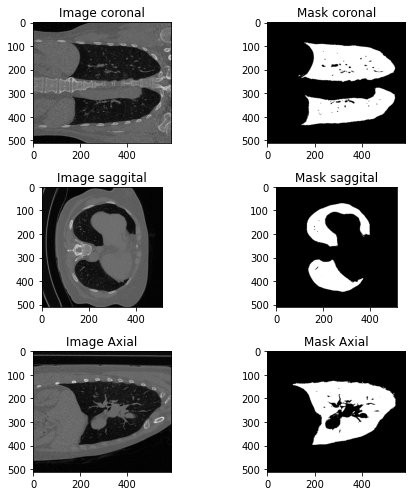

In [ ]:
# Plot the images 
c='gray'
plt.figure(figsize=(7,7))
plt.subplot(321) , plt.imshow(image_coronal ,cmap=c), plt.title('Image coronal')
plt.subplot(322) , plt.imshow(mask_coronal  ,cmap=c), plt.title('Mask coronal')
plt.subplot(323) , plt.imshow(image_saggital,cmap=c), plt.title('Image saggital')
plt.subplot(324) , plt.imshow(mask_saggital ,cmap=c), plt.title('Mask saggital')
plt.subplot(325) , plt.imshow(image_axial   ,cmap=c), plt.title('Image Axial')
plt.subplot(326) , plt.imshow(mask_axial    ,cmap=c), plt.title('Mask Axial')
plt.tight_layout()

### Initial data exploration

Here we look at the distribution of the pixels. CT pixel values are based on Hounsfield Unit (HU). The HU for Air is -1000, for water is 0, and for Bones is +1000. The values in between this range are a linear combination between the categories. For example, a pixel with HU of -500 has 1/2 air and 1/2 tissue (water). 

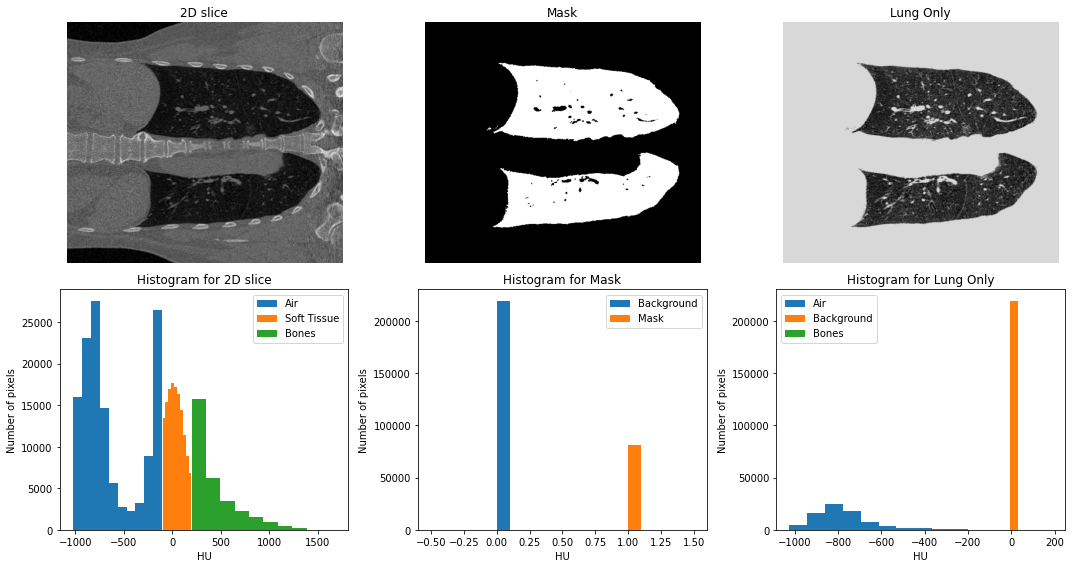

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(231) , plt.imshow(image_coronal, cmap='gray'), plt.title('2D slice') , plt.axis('off')
plt.subplot(232) , plt.imshow(mask_coronal, cmap='gray')  , plt.title('Mask') , plt.axis('off')
plt.subplot(233) , plt.imshow(mask_coronal * image_coronal, cmap='gray') , plt.title('Lung Only') , plt.axis('off') 

plt.subplot(234) 
slice_air = np.ravel(image_coronal[image_coronal< -100])
slice_softTissue = np.ravel(image_coronal[(image_coronal> -100) & (image_coronal < 200)])
slice_bone = np.ravel(image_coronal[image_coronal> 200])
plt.hist(slice_air, label='Air' , align='mid')
plt.hist(slice_softTissue ,label= 'Soft Tissue', align='mid')
plt.hist(slice_bone, label ='Bones', align='mid')
plt.legend()
plt.xlabel('HU')
plt.ylabel('Number of pixels')
plt.title('Histogram for 2D slice')

plt.subplot(235)
mask_bg = np.ravel(mask_coronal[mask_coronal==0])
mask_ones = np.ravel(mask_coronal[mask_coronal != 0])
plt.hist(mask_bg, label='Background' , align='mid')
plt.hist(mask_ones ,label= 'Mask', align='mid')
plt.legend()
plt.xlabel('HU')
plt.ylabel('Number of pixels')
plt.title('Histogram for Mask')

plt.subplot(236)
im =(mask_coronal * image_coronal)
slice_air = np.ravel(im[im < -200])
slice_softTissue = np.ravel( im[(im > -200) & (im < 200)])
slice_bone = np.ravel(im[im> 200])
plt.hist(slice_air, label='Air' , align='mid')
plt.hist(slice_softTissue ,label= 'Background', align='mid')
plt.hist(slice_bone, label ='Bones', align='mid')
plt.legend()
plt.xlabel('HU')
plt.ylabel('Number of pixels')
plt.title('Histogram for Lung Only') 
plt.xlabel('HU') 


plt.tight_layout()
plt.show()

This figure shows the HU distribution on a sample 2D slice. The lung is actually very easy to be segmented because of the high contrast betwene the lung (air) and the surrounding tissues. We further look at the distribution of these categories in the whole dataset. For simplification purpose, we define:
  * Air ( HU < -200) 
  * Soft tissues (-200 < HU < 200) 
  * Bones( HU > 200 ) 

In [ ]:
counter = 0 
training_array = []
for file in os.listdir(Data_folder+ '/images_train'):
  nifti = os.path.join(Data_folder,'images_train',file)
  image = nib.load(nifti).get_fdata()
  training_array.append(image)
  counter += 1
  if counter == 3:
    break
bone = 0
soft_tissue= 0
air = 0
for entry in training_array:
  a= entry
  b = a.reshape(-1)
  bone += len(b[b>200])
  soft_tissue += len(b[(b > -200)&( b < 200)])
  air += len(b[b<-200])

total = bone + soft_tissue + air
x = [bone/total*100, soft_tissue/total*100, air/total*100]
names = ['Bone','Soft Tissue','Air']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


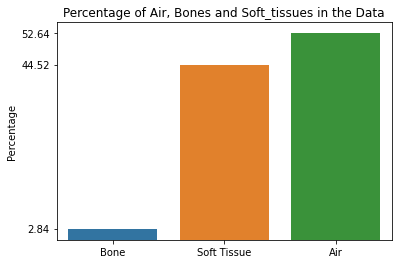

In [ ]:
import seaborn as sns
sns.barplot(names, x)
plt.yticks(x) 
plt.ylabel('Percentage')
plt.title("Percentage of Air, Bones and Soft_tissues in the Data") 
plt.show()

We notice that the air has the highest ratio in the dataset as most of the images have background air. The dataset is balanced and the segmentation task for the whole lung region should be an easy task. 

## Data Preprocessing 

Here we prepare the images for machine learning. 
  * Encode the patient ID into simple terms, numbers from 0 to 17.
  * Split the 3D volume images into 2D coronal slices.
  * Save the slices in x_train, y_train, x_test, y_test folders

#### Simplify subject ID

In [ ]:
# Encode the subject number into simpler terms
Data_folder = os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS','CIS545_project','Data', 'Lung')
subject_keys = {}
i = 0 
print(' '*16, 'Old Subject ID', ' '* 25, 'New ID')
for subject in os.listdir(Data_folder+ '/images_train') + os.listdir(Data_folder+ '/images_test'):
  subject_keys[subject] = str(i)
  i+= 1
  # Print new subject id 
  spaces = 57 - len(subject)
  print(subject,' '*spaces,subject_keys[subject])


                 Old Subject ID                           New ID
x10796V_EXP_SHARP_TEM_COPD_10796V_TEM_COPD.nii.gz          0
x10866Q_INSP_B46f_328_TEM_COPD2_10866Q_TEM_COPD.nii.gz     1
x11112W_EXP_B46f_349_TEM_COPD2_11112W_TEM_COPD.nii.gz      2
x11435U_EXP_STD_TEM_COPD_11435U_TEM_COPD.nii.gz            3
x11489R_INSP_B31f_355_TEM_COPD2_11489R_TEM_COPD.nii.gz     4
x11571C_INSP_STD_TEM_COPD_11571C_TEM_COPD.nii.gz           5
x11677S_EXP_STD_TEM_COPD_11677S_TEM_COPD.nii.gz            6
x11775S_INSP_STD_TEM_COPD_11775S_TEM_COPD.nii.gz           7
x12055P_INSP_B31f_326_TEM_COPD2_12055P_TEM_COPD.nii.gz     8
x12244S_INSP_B46f_365_TEM_COPD2_12244S_TEM_COPD.nii.gz     9
x12287K_INSP_SHARP_TEM_COPD_12287K_TEM_COPD.nii.gz         10
x12343U_EXP_B31f_358_TEM_COPD2_12343U_TEM_COPD.nii.gz      11
x12428C_EXP_B46f_329_TEM_COPD2_12428C_TEM_COPD.nii.gz      12
x12434X_EXP_SHARP_TEM_COPD_12434X_TEM_COPD.nii.gz          13
x12560C_EXP_B46f_325_TEM_COPD2_12560C_TEM_COPD.nii.gz      14
x10408M_EXP_B46

#### Create train and test folders

Now we split the 3D volume into 2D images. We create:
  * x_train, y_train, x_test, y_test directories 

This step is done only once and aims to speed up the training process.

  * The mask files are zeros and ones so we save them as png files 8bit unsigned format. 

  * The image files are 16 bit unsigned int so we save them as tiff files.


Note: Jpg, a lossy compression, changes the pixel values. This is why we used png, a lossless compression, to store the mask slices.  

In [ ]:
'''
function to extract coronal slices from 3D volume
Given: 
  image_name    : the 3D volume filename, nifti format
** Optional 
  save_name     : slices are saved as 'save_name'_sliceNumber.png/tiff
                  default is 'image_name'_sliceNumber.png/tiff
  out_path      : where the slices will be saved
  mask          : True  -> save as unsigned 9 bits in png  format
                  False -> save as signed 16 bites in tiff format
'''
def extract_slices(image_name,save_name='',out_path='',mask=False):
    # Extract 2D slices from 3D images. 
    if save_name == '': save_name = image_name.split('/')[-1]
    if out_path  == '': out_path  = '.'
    if not os.path.isdir(out_path): os.mkdir(out_path)

    im = nib.load(image_name).get_fdata()
    slices = np.arange(im.shape[1])
    for aslice in slices: 
        if mask:  
            arr = im[:,aslice,:].astype(np.uint8)
            new_im = Image.fromarray(arr)
            new_im.save(out_path+'/'+save_name+'_'+str(aslice)+'.png') # png is 8bits (0,255) and no lossy compression
        else:
            arr = im[:,aslice,:].astype(np.int16)
            new_im = Image.fromarray(arr)
            new_im.save(out_path+'/'+save_name+'_'+str(aslice)+'.tiff') # tiff is 16bit (-32,768 to 32,767)
    return 0

In [ ]:
# x_train
for file in os.listdir(Data_folder+ '/images_train'):
  image_name = os.path.join(Data_folder,'images_train',file)
  out_path   = os.path.join(Data_folder,'x_train')
  x = extract_slices(image_name,save_name=subject_keys[file],out_path=out_path,mask=False)

In [ ]:
# x_test 
for file in os.listdir(Data_folder+ '/images_test'):
  image_name = os.path.join(Data_folder,'images_test',file)
  out_path   = os.path.join(Data_folder,'x_test')
  x = extract_slices(image_name,save_name=subject_keys[file],out_path=out_path,mask=False)

In [ ]:
# y_train
for file in os.listdir(Data_folder+ '/mask_train'):
  image_name = os.path.join(Data_folder,'mask_train',file)
  out_path   = os.path.join(Data_folder,'y_train')
  x = extract_slices(image_name,save_name=subject_keys[file.replace('_m','')],out_path=out_path,mask=True)

In [ ]:
# y_test
for file in os.listdir(Data_folder+ '/mask_test'):
  image_name = os.path.join(Data_folder,'mask_test',file)
  out_path   = os.path.join(Data_folder,'y_test')
  x = extract_slices(image_name,save_name=subject_keys[file.replace('_m','')],out_path=out_path,mask=True)

#### Create Custom Dataset

We create a custom dataset that inherits from the PyTorch Dataset class. It reads the images in the folders (x_train, y_train, x_test, y_test). 

In [ ]:
'''
This function takes a numpy array and normalize it to (0,1)
It used the knowledge from preprocessing the images
The minimum value is -1024 
The maximum value used is 2000 because we only care about the values 
in the negatic range.

* returns the normalized array
'''
def normalize_0_1(array):
  mymin = -1024
  mymax = 2000
  array[array > 2000] = 2000 
  return (array - mymin) / (mymax - mymin)

In [ ]:
class Lung_dataset(Dataset):
  def __init__(self,root_dir, transform_image=None, transform_mask=None, train=False, test=False):

    if not train and not test:
      print('Error! You must choose train or test dataset!')
      return 

    self.transform_image =transform_image
    self.transform_mask  = transform_mask 

    if train: 
      self.data_path  = os.path.join(root_dir,'x_train')
      self.label_path = os.path.join(root_dir,'y_train')
    
    if test:
      self.data_path  = os.path.join(root_dir,'x_test')
      self.label_path = os.path.join(root_dir,'y_test')

  def __len__(self):
    return len(os.listdir(self.data_path)) 

  def __getitem__(self,index):
      image_name = os.listdir(self.data_path)[index].split('.')[0]
      # Note: Data is in .tiff, label is on .png 
      image = os.path.join(self.data_path, image_name+'.tiff')
      label = os.path.join(self.label_path, image_name+'.png')

      image = normalize_0_1(np.array(Image.open(image))).astype(np.float32)
      label = np.array(Image.open(label))  

      if self.transform_image: image = self.transform_image(image)
      if self.transform_mask : 
        # multiply label by 255 because transform works on Images 
        # We want the the mask after transform to be 1s and 0s
        label = self.transform_mask(label*255) 
      return image,label

#### Load files, Transform and Dataloader

In [ ]:
#Data_folder = os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS','CIS545_project','Data', 'Lung')
Data_folder = os.path.join(DRIVE_MOUNT, 'My Drive','CIS545_project','Data', 'Lung') # correct path for shared folder after creating shared folder shortcut in My Drive
batch_size = 32
transform_image = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224))])

# Use Nearest Neighbor interpolation for the mask
transform_mask = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224),
                                                  transforms.InterpolationMode.NEAREST)])

# Train
train_dataset= Lung_dataset(Data_folder, train=True, transform_image=transform_image, transform_mask=transform_mask)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,num_workers=2, shuffle=True)

# Test 
test_dataset= Lung_dataset(Data_folder, test =True, transform_image=transform_image, transform_mask=transform_mask)
test_loader = DataLoader(dataset=test_dataset, batch_size=32,num_workers=2, shuffle=True)

In [ ]:
for x,y in train_loader:
  print(f'x = shape: {x.shape}; type: {x.dtype}')
  print(f'x = min: {x.min()}; max: {x.max()}')
  print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
  break

x = shape: torch.Size([32, 1, 224, 224]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([32, 1, 224, 224]); class: tensor([0., 1.]); type: torch.float32


#### Visualize the training images 

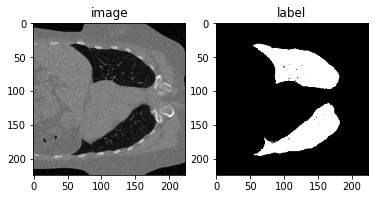

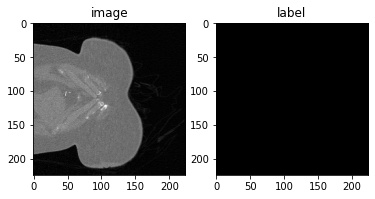

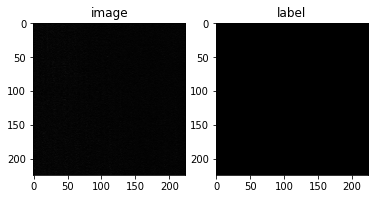

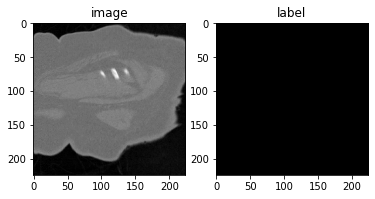

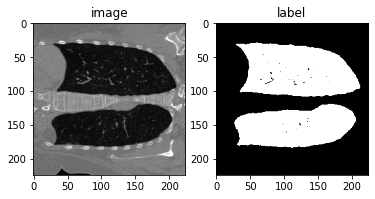

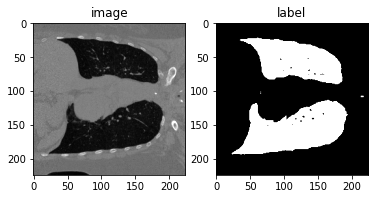

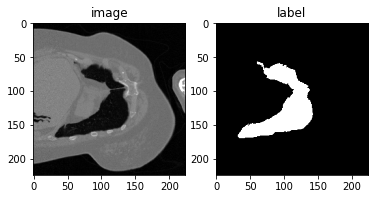

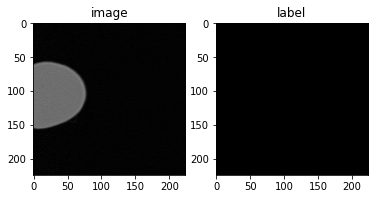

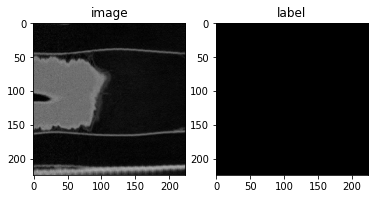

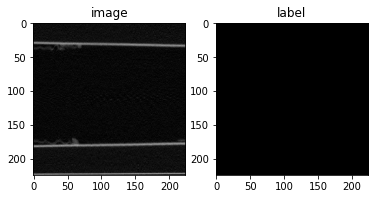

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.subplot(121)
    plt.imshow(data[0,:,:], cmap='gray',vmin=0,vmax=0.7)
    plt.title('image')
    plt.subplot(122)
    plt.imshow(label[0,:,:],cmap='gray',vmin=0,vmax=0.7)
    plt.title('label')
    plt.show()

## Machine Learning

Our goal is to perform semantic segmentation of MRI images of the lungs. For this, we will train and test three different neural network models. Our first model will be a simple FCNN built from scratch to obtain base performance on our training and test sets. For our second and third models, we will use existing architectures made available through PyTorch, specifically U-Net and FCN-ResNet.

### Train and Test Functions

In [ ]:
def train_model(model,train_loader, optimizer, criterion, epochs=10, print_batch_metrics = False, resnet_flag = False):
    model.train()
    model.to(device)

    loss_list, accuracy_list, recall_list = [], [], []
    for i in range(1,epochs+1):
      epoch_loss,epoch_recall = [],[]
      total,correct,batch_num = 0,0,1
      batch_loss, batch_acc, batch_recall = np.array([]), np.array([]),np.array([])
      for x,y in tqdm(train_loader):
        x,y = x.to(device), y.to(device) # Put the image to the GPU if any
        y = y.squeeze(1)
        # Train
        optimizer.zero_grad()            # Reset the gradients 
        if resnet_flag: 
          out = model(x)['out']            # Train the model, specific to FCN-ResNet101
        else:
          out = model(x)
        out = out.squeeze(1)
        loss   = criterion(out, y)       # Binary Cross Entropy loss with logits
        loss.backward()                 # Calculate sgd wrt w 
        optimizer.step()                # Update the weights
        # Thresholding the logics to 1 and 0
        out[out < 0.5] = 0
        out[out >= 0.5] = 1
        # Calculate loss, accuraccy, and recall
        loss, acc, recall, b_correct, b_total = calculate_batch_metrics(y,out,loss)
        batch_loss   = np.append(batch_loss,loss)
        batch_acc    = np.append(batch_acc,acc)
        batch_recall = np.append(batch_recall,recall)
        epoch_loss.append(loss)
        epoch_recall.append(recall)
        correct += b_correct
        total   += b_total 
        if print_batch_metrics and batch_num % 10 == 0:
          print(' Batch_loss = ', round(np.mean(batch_loss),2),
                '   - Batch_recall = ',round(np.nanmean(batch_recall),2),
                '   - Batch_accuracy = ', round(np.mean(batch_acc),2))
          batch_loss, batch_acc, batch_recall = np.array([]), np.array([]),np.array([])
        batch_num +=1
      # Epoch calculations
      epoch_loss = sum(epoch_loss) / len(epoch_loss)
      epoch_acc  = correct / total * 100
      epoch_recall = sum(epoch_recall) / len(epoch_recall)
      # Save metrics
      loss_list.append(epoch_loss) 
      accuracy_list.append(epoch_acc)
      recall_list.append(epoch_recall)
      print('Epoch:'    ,i,
            ' - Loss:', round(epoch_loss,2),
            ' - Accuracy:', round(epoch_acc,2),
            ' - Recall:', round(epoch_recall,2))          
    # return loss_list, accuracy_list, recall_list
    return batch_loss, batch_acc, batch_recall

In [ ]:
def calculate_batch_metrics(y,out,loss):
  # Calculate loss, accuraccy, and recall
  loss    = loss.item()
  correct = (out==y).sum().item()
  total   = len(y.ravel())

  number_of_ones = y.sum().item()     
  correct_predictions_ones = ((y==1) * (out==1)).sum().item()
  
  acc = correct / total * 100
  recall = np.nan 
  if number_of_ones !=0: 
    recall = correct_predictions_ones / number_of_ones * 100 
  return loss, acc, recall, correct, total

In [ ]:
def test_model(model, criterion, max_num = None, resnet_flag = False):
    model.eval()
    model.to(device)
    # TODO: Implement your testing loop with the `test_loader` data
    total,correct,loss = 0,0,0
    total_ones, correct_ones = 0,0
    i = 0
    with torch.no_grad():
      for x,y in tqdm(test_loader):
        x,y = x.to(device) , y.to(device)
        if resnet_flag: 
          out = model(x)['out']            # specific to FCN-ResNet101
        else:
          out = model(x)
        loss_cr = criterion(out,y)
        out[out >0.5] = 1
        out[out<= 0.5] =  0
        loss   += loss_cr.item()
        correct += (out==y).sum().item()
        correct_ones += ((out==1) * (y==1)).sum().item()
        total += len(torch.ravel(y))
        total_ones  += (y==1).sum().item()
        i += x.shape[0]
        if max_num and i >= max_num:
          break
    
    testing_loss     =   loss/total      
    testing_accuracy =   correct/total    * 100
    testing_recall   =   correct_ones / total_ones * 100
    print('Loss:', round(testing_loss,2),
      ' - Accuracy:', round(testing_accuracy,2),
      ' - Recall:', round(testing_recall,2)) 
    return  testing_loss, testing_accuracy, testing_recall

### Model 1: simple FCNN

#### Create the model

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1 , out_channels=16 , kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32 , kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16 , kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=1  , kernel_size=3,padding=1)

    def forward(self, x):
      x = torch.relu(self.conv1(x)) 
      x = torch.relu(self.conv2(x))
      x = torch.max_pool2d(x, (2,2))
      x = torch.relu(self.conv3(x))
      x = F.interpolate(x, scale_factor=2)
      x = self.conv4(x)
      return x
fcnn_model = FCNN()

#### Train

In [ ]:
optimizer = torch.optim.Adam(fcnn_model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
start_time = time.time()
loss,accuracy, recall = train_model(fcnn_model,train_loader, optimizer, criterion, epochs=1)
torch.save(fcnn_model.state_dict(), Data_folder +'/trained_simple_fcnn.pt' )
print('Took: ', round((time.time()-start_time)/60,2), 'minutes' )

100%|██████████| 240/240 [42:41<00:00, 10.67s/it]


Epoch: 1  - Loss: 0.42  - Accuracy: 0.9  - Recall: 0.0
Took:  42.86829423507054 minutes


#### Loss, accuracy and recall metrics for training phase

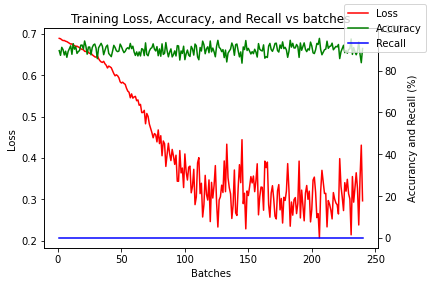

In [ ]:
fig, ax1 = plt.subplots()
batches = np.arange(1,len(loss)+1)
ax2 = ax1.twinx()
ax1.plot(batches,loss,color = 'red',label='Loss')
ax2.plot(batches,accuracy,color ='g',label='Accuracy')
ax2.plot(batches,recall,color ='b',label='Recall')
ax1.set_xlabel('Batches')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accurancy and Recall (%)')
ax1.set_title('Training Loss, Accuracy, and Recall vs batches')
fig.tight_layout()
fig.legend()

#### Test 

In [ ]:
fcnn_model.load_state_dict(torch.load(Data_folder +'/trained_simple_fcnn.pt'))
optimizer = torch.optim.Adam(fcnn_model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
test_loader = DataLoader(dataset=test_dataset, batch_size=32,num_workers=2, shuffle=True)
loss, acc, recall = test_model(fcnn_model, criterion)

100%|██████████| 48/48 [00:33<00:00,  1.42it/s]

Loss: 0.0  - Accuracy: 91.68  - Recall: 0.0


The accuracy for this simple fcnn is 91.68% but the recall is 0%! The model is just predicting zeros with no label at all! Let's train it for more epochs.

#### Additional Training and Testing

In [ ]:
fcnn_model.load_state_dict(torch.load(Data_folder +'/trained_simple_fcnn.pt'))
optimizer = torch.optim.Adam(fcnn_model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
start_time = time.time()
loss,accuracy, recall = train_model(fcnn_model,train_loader, optimizer, criterion, epochs=2)
torch.save(fcnn_model.state_dict(), Data_folder +'/trained_simple_fcnn.pt' )
print('Took: ', round((time.time()-start_time)/60,2), 'minutes' )

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 1  - Loss: 0.31  - Accuracy: 89.97  - Recall: 0.0


100%|██████████| 240/240 [30:22<00:00,  7.59s/it]


Epoch: 2  - Loss: 0.28  - Accuracy: 89.97  - Recall: 0.0
Took:  66.03 minutes


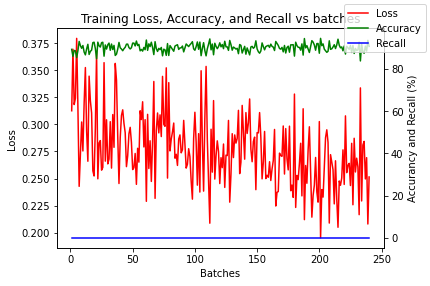

In [ ]:
fig, ax1 = plt.subplots()
batches = np.arange(1,len(loss)+1)
ax2 = ax1.twinx()
ax1.plot(batches,loss,color = 'red',label='Loss')
ax2.plot(batches,accuracy,color ='g',label='Accuracy')
ax2.plot(batches,recall,color ='b',label='Recall')
ax1.set_xlabel('Batches')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accurancy and Recall (%)')
ax1.set_title('Training Loss, Accuracy, and Recall vs batches')
fig.tight_layout()
fig.legend()

### Model 2: U-NET

#### Create the model

The U-Net architecture is shown below. We changed it a little bit to have only 1 input channel and with image size of 224x224.

![pixture](https://pytorch.org/assets/images/unet_brain_mri.png)

In [ ]:
# Check the reference for unet implementation
unet_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


#### Train

In [ ]:
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
start_time = time.time()
loss,accuracy, recall = train_model(unet_model,train_loader, optimizer, criterion, epochs=1)
torch.save(unet_model.state_dict(), Data_folder +'/trained_unet.pt' )
print('Took: ', round((time.time()-start_time)/60,2), 'minutes' )

100%|██████████| 240/240 [37:34<00:00,  9.39s/it]


Epoch: 1  - Loss: 0.84  - Accuracy: 0.96  - Recall: 98.72
Took:  37.63 minutes


#### Loss, accuracy and recall metrics for training phase

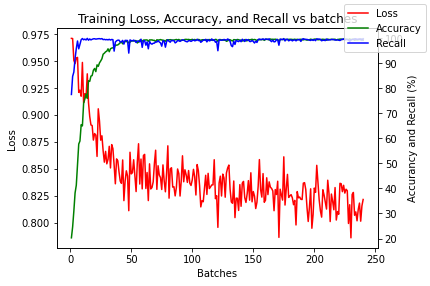

In [ ]:
fig, ax1 = plt.subplots()
batches = np.arange(1,len(loss)+1)
ax2 = ax1.twinx()
ax1.plot(batches,loss,color = 'red',label='Loss')
ax2.plot(batches,accuracy,color ='g',label='Accuracy')
ax2.plot(batches,recall,color ='b',label='Recall')
ax1.set_xlabel('Batches')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accurancy and Recall (%)')
ax1.set_title('Training Loss, Accuracy, and Recall vs batches')
fig.tight_layout()
fig.legend()

#### Test

In [ ]:
unet_model.load_state_dict(torch.load(Data_folder +'/trained_unet.pt'))
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
test_loader = DataLoader(dataset=test_dataset, batch_size=32,num_workers=2, shuffle=True)
loss, acc, recall = test_model(unet_model, criterion)

100%|██████████| 48/48 [00:36<00:00,  1.33it/s]

Loss: 0.0  - Accuracy: 99.56  - Recall: 99.16


It looks like U-Net is very good for this segmentation task. Only one epoch and we're getting 99.5% accuracy and 99.16% recall on the test dataset. Great Job! 

### Model 3: FCN-ResNet101

"FCN-ResNet101 is constructed by a Fully-Convolutional Network model with a ResNet-101 backbone. The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset." (reference: https://pytorch.org/hub/pytorch_vision_fcn_resnet101/)

Here we used the pretrained resnet, and further trained it on our dataset. 

#### Create the model

Inspect layers of FCN-ResNet101 backbone (reference: https://pytorch.org/hub/pytorch_vision_fcn_resnet101/)

In [ ]:
# Load FCN-ResNet101 model to evaluate architecture
model_inspect = torch.hub.load('pytorch/vision:v0.9.0', 'fcn_resnet101', pretrained=True)
model_inspect.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Model initialization (reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [ ]:
# Finetuning helper function
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Number of classes
num_classes = 1
# Flag for feature extracting, False means finetune whole model, True means only update reshaped layers parameters
feature_extract = False
# Load FCN-ResNet101
model_resnet = torch.hub.load('pytorch/vision:v0.9.0', 'fcn_resnet101', pretrained=True)
# Obtain parameters to optimize depending on feature_extract flag
set_parameter_requires_grad(model_resnet, feature_extract)
# Modify number of channels in first layer
model_resnet.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Modify number of output classes in primary classifier
model_resnet.classifier = torch.nn.Sequential(
    nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1, inplace=False),
    nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    )
# Modify number of output classes in auxilary classifier
model_resnet.aux_classifier = torch.nn.Sequential(
    nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1, inplace=False),
    nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    )
# Send the model to GPU
model_resnet = model_resnet.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


Set up parameters to optimize (reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [ ]:
# Obtain parameters to update during training phase depending on amount of finetuning
params_to_update = model_resnet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_resnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_resnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 backbone.conv1.weight
	 backbone.bn1.weight
	 backbone.bn1.bias
	 backbone.layer1.0.conv1.weight
	 backbone.layer1.0.bn1.weight
	 backbone.layer1.0.bn1.bias
	 backbone.layer1.0.conv2.weight
	 backbone.layer1.0.bn2.weight
	 backbone.layer1.0.bn2.bias
	 backbone.layer1.0.conv3.weight
	 backbone.layer1.0.bn3.weight
	 backbone.layer1.0.bn3.bias
	 backbone.layer1.0.downsample.0.weight
	 backbone.layer1.0.downsample.1.weight
	 backbone.layer1.0.downsample.1.bias
	 backbone.layer1.1.conv1.weight
	 backbone.layer1.1.bn1.weight
	 backbone.layer1.1.bn1.bias
	 backbone.layer1.1.conv2.weight
	 backbone.layer1.1.bn2.weight
	 backbone.layer1.1.bn2.bias
	 backbone.layer1.1.conv3.weight
	 backbone.layer1.1.bn3.weight
	 backbone.layer1.1.bn3.bias
	 backbone.layer1.2.conv1.weight
	 backbone.layer1.2.bn1.weight
	 backbone.layer1.2.bn1.bias
	 backbone.layer1.2.conv2.weight
	 backbone.layer1.2.bn2.weight
	 backbone.layer1.2.bn2.bias
	 backbone.layer1.2.conv3.weight
	 backbone.layer1.2.bn

#### Train

In [ ]:
optimizer = torch.optim.Adam(params_to_update, lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
start_time = time.time()
loss, accuracy, recall = train_model(model_resnet, train_loader, optimizer, criterion, epochs=1, print_batch_metrics=False)
torch.save(model_resnet.state_dict(), Data_folder +'/trained_fcnn-resnet-101_final_3.pt')
print('Took: ', round((time.time()-start_time)/60,2), 'minutes' )

100%|██████████| 240/240 [59:17<00:00, 14.82s/it]


Epoch: 1  - Loss: 0.07  - Accuracy: 98.75  - Recall: 93.48
Took:  59.31 minutes


#### Loss, accuracy and recall metrics for training phase

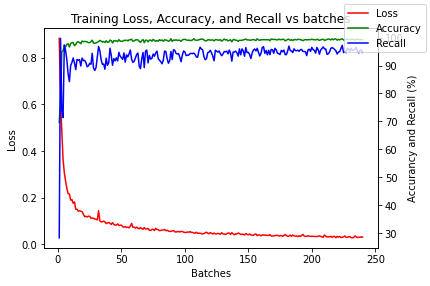

In [ ]:
fig, ax1 = plt.subplots()
batches = np.arange(1,len(loss)+1)
ax2 = ax1.twinx()
ax1.plot(batches,loss,color = 'red',label='Loss')
ax2.plot(batches,accuracy,color ='g',label='Accuracy')
ax2.plot(batches,recall,color ='b',label='Recall')
ax1.set_xlabel('Batches')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accurancy and Recall (%)')
ax1.set_title('Training Loss, Accuracy, and Recall vs batches')
fig.tight_layout()
fig.legend()

#### Test

In [ ]:
model_resnet.load_state_dict(torch.load(Data_folder +'/trained_fcnn-resnet-101_final_3.pt'))
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
test_loader = DataLoader(dataset=test_dataset, batch_size=32,num_workers=2, shuffle=True)
loss, acc, recall = test_model(model_resnet, criterion)

100%|██████████| 48/48 [09:42<00:00, 12.14s/it]

Loss: 0.0  - Accuracy: 99.31  - Recall: 94.5


FCN-ResNet101 model performed well on test set! Accuracy = 99.31 and Recall = 94.5. Note, the U-Net model from earlier performed even better on this segmentation task according to these metrics.

### ROC and Model Comparison

To better understand model differences we performed ROC analysis.

#### ROC functions

In [ ]:
def get_roc(model, model_name):
  # Initialize the model
  model.load_state_dict(torch.load(Data_folder +'/'+model_name+'.pt'))
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  criterion = torch.nn.BCEWithLogitsLoss()
  test_loader = DataLoader(dataset=test_dataset, batch_size=32,num_workers=2, shuffle=True)
  # run the model
  model.eval()
  model.to(device)
  ground_truth_labels = [] # ground truth labels 0s and 1s
  predicted_scores    = [] # the prediction logits form 0 to 1 (probabilities)
  with torch.no_grad():
    for x,y in tqdm(test_loader):
      x,y = x.to(device) , y.to(device)
      #out = model(x)
      out = model(x)['out']            # Train the model, specific to FCN-ResNet101
      ground_truth_labels.append(torch.ravel(y).cpu().numpy())
      predicted_scores.append(torch.ravel(out).cpu().numpy())

  
  ground_truth_labels = np.ravel(ground_truth_labels)
  predicted_scores    = np.ravel(predicted_scores)
  fpr, tpr, _ = roc_curve(ground_truth_labels,predicted_scores)
  roc_auc = auc(fpr,tpr)
  return fpr, tpr, roc_auc 

In [ ]:
def plot_roc(fpr, tpr, roc_auc,title=''):
  fig, ax = plt.subplots(1,1)
  ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('ROC for '+title)
  ax.legend(loc="lower right")

#### ROC comparison

100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


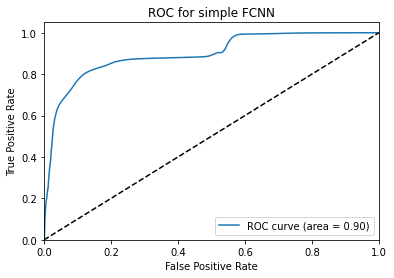

In [ ]:
# FCNN 
fpr, tpr, roc_auc  = get_roc(fcnn_model, 'trained_simple_fcnn')
plot_roc(fpr, tpr, roc_auc,title='simple FCNN')

100%|██████████| 48/48 [00:41<00:00,  1.15it/s]


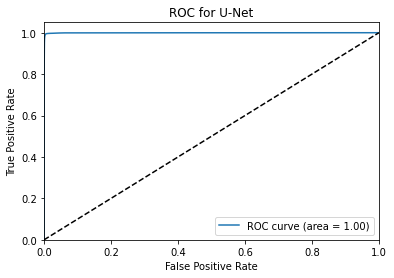

In [ ]:
# U-Net
fpr, tpr, roc_auc  = get_roc(unet_model, 'trained_unet')
plot_roc(fpr, tpr, roc_auc, title='U-Net' ) 

100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


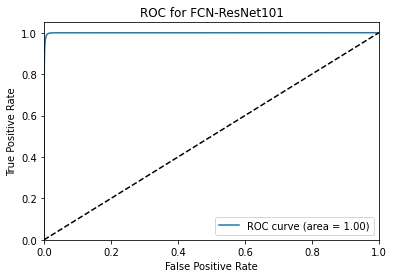

In [ ]:
# FCN-ResNet101
fpr, tpr, roc_auc  = get_roc(model_resnet, 'trained_fcnn-resnet-101_final_3')
plot_roc(fpr, tpr, roc_auc, title='FCN-ResNet101' ) 

The comparison showed us that FCN-ResNET and U-Net performed very well in segmenting the lung. The ROC also shows that if we changed the threshold for simple FCNN (hard-coded as 0.5), it would have performed much better. 

## Test Run on actual 3D CT Image

Here we present a pipeline function to automate the process of preprocessing and segmenting nifti files. We directly use the trained model to segment a 3D image.

The goal is to give a nifti file and get the mask for it. Here we create a dataset and a function to automatically load and segment the nifti files. We extract 2D slices, downsample them, get the predicted mask, upsample the output using nearest neighbor, combine the 2D slices using the header and affine transformation from the original nifti image and save the output. 

In [ ]:
# Read a nifti image 
nifti_file = Data_folder + '/images_test/x10408M_EXP_B46f_402_TEM_COPD2_10408M_TEM_COPD.nii.gz'
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)
model.load_state_dict(torch.load( Data_folder +'/trained_unet.pt'))

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

#### Run functions

In [ ]:
# Dataset to prepare one nifti file to be segmented
class image_dataset(Dataset):
  def __init__(self,nifti_file_path, transform = None):
    self.image = nib.load(nifti_file_path).get_fdata()
    self.transform = transform 

  def __len__(self):
    return self.image.shape[1]

  def __getitem__(self,index):
    # image = normalize_0_1(np.array(Image.open(image))).astype(np.float32) # 
    aslice = normalize_0_1(self.image[:,index,:]).astype(np.float32)
    aslice = torch.from_numpy(aslice).unsqueeze(0)
    if self.transform:
      aslice = self.transform(aslice)

    return aslice

In [ ]:
def segment(nifti_filename, model):
    model.eval()
    model.to(device)
    total,correct,loss = 0,0,0
    total_ones, correct_ones = 0,0
    segmented_image = []
    image = nib.load(nifti_filename)
    affine, header = image.affine, image.header 
    image = image.get_fdata()
    shape = image.shape 
    with torch.no_grad():
      for x in tqdm(image_loader) :
        out = model(x.to(device))
        _, predicted = torch.max(out, 1)
        segmented_image.append(predicted) 
    # Rescale 
    out = torch.cat(segmented_image)
    out = transforms.Resize((shape[0],shape[2]), interpolation=transforms.InterpolationMode.NEAREST)(out).squeeze()
    out = out.permute(1, 0, 2)
    out = out.cpu().detach().numpy()
    img = nib.Nifti1Image(out, affine,header)
    return  img

#### Run

In [ ]:
# Load the file
transform = transforms.Resize((224,224))
image = image_dataset(nifti_file, transform=transform) 
image_loader = DataLoader(dataset=image, batch_size=32,num_workers=2, shuffle=False)

In [ ]:
out = segment(nifti_file, model)

100%|██████████| 16/16 [00:03<00:00,  4.87it/s]


In [ ]:
out.to_filename(Data_folder +'/out_m.nii.gz')

#### Visualize the performace

The true and predicted 3D volume masks were opened in ITK-SNAP software, a medical imaging analysis application. The Images shown below show the great performance of the U-Net model in segmenting the lung regions.

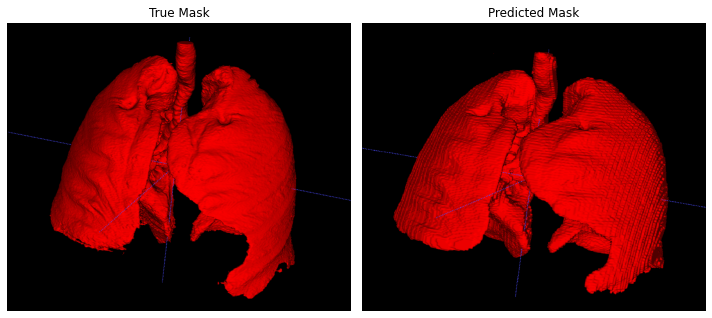

In [ ]:
y = Image.open(Data_folder+'/true.png')
y_pred = Image.open(Data_folder +'/prediction.png')
y_pred = y_pred.resize(y.size, resample=Image.NEAREST)
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(y) , plt.axis('off'), plt.title('True Mask')
plt.subplot(122)
plt.imshow(y_pred), plt.axis('off'), plt.title('Predicted Mask')
fig.tight_layout()

##Limitations of current approach

Here we show a limitation to our implemtations using MRI brain images as a show case. The contrast between the hippocampus and the surrouding tissues are much worse than that of the lung. Furthermore, the dataset is highly imbalanced as most of the images do not have the hiipocampus. 

To further understand how well our models perform semantic segmentation on medical images, we explored a dataset containing labeled MRI images of the hippocampus. In contrast to excellent performance on the CT lungs dataset, the accuracy of the ML models remained low for hippocampus segmentation, even after cleaning the data. 


### Data

Here we show the data structure, number of images, and an explanation for the label

In [ ]:
Data_folder = os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS','CIS545_project','Data', 'MRI')

In [ ]:
# number_of_images = len(os.listdir(Data_folder+'/x_train')) + len(os.listdir(Data_folder+'/x_test'))
# print('We have', number_of_images, 'images.')

In [ ]:
# Images Path
y_train_dir =  os.path.join(Data_folder,'label','100label')
x_train_dir =  os.path.join(Data_folder,'original','100')
subject = 'ADNI_002_S_0295_13722_ACPC'
image_name      = '_'.join(subject.split('_')[:-1])
image_index     = '_074'
# Get original image
subject_dir_x   = os.path.join(x_train_dir, subject)
# Get the label
subject_dir_y   = os.path.join(y_train_dir, subject)
subject_left_y  = os.path.join(subject_dir_y,image_name +'_L')
subject_right_y = os.path.join(subject_dir_y,image_name +'_R')
image_x   = [os.path.join(subject_dir_x,x)   for x in os.listdir(subject_dir_x) if image_index in x][0]
image_y_L = [os.path.join(subject_left_y,x)  for x in os.listdir(subject_left_y) if image_index in x][0]
image_y_R = [os.path.join(subject_right_y,x) for x in os.listdir(subject_right_y) if image_index in x][0]

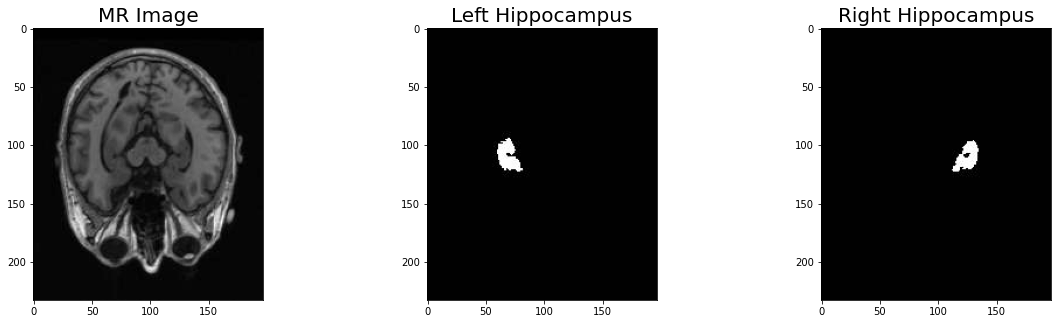

In [ ]:
im_left  = ImageOps.grayscale(Image.open(image_y_L))
im_right = ImageOps.grayscale(Image.open(image_y_R)) 
im_orig  = ImageOps.grayscale(Image.open(image_x))
# im_orig  = ImageOps.grayscale(im_orig)
# im_right  = ImageOps.grayscale(im_right)


plt.figure(figsize = (20,5))
plt.subplot(131)
plt.title('MR Image',fontsize=20)
plt.imshow(im_orig,cmap='gray')

plt.subplot(132)
plt.title('Left Hippocampus',fontsize=20)
plt.imshow(im_left,cmap='gray')

plt.subplot(133)
plt.title('Right Hippocampus',fontsize=20)
plt.imshow(im_right,cmap='gray')


In [ ]:
counter = 0 
training_array = []
for file in os.listdir( Data_folder + '/y_train' ):
  try:
    file = os.path.join(Data_folder + '/y_train',file)
    image = Image.open(file)
    training_array.append(np.ravel(image))
    counter += 1
    if counter == 500:
      break
  except:
    print(file)

Text(0.5, 1.0, 'Histogram for the hippocampus mask for 500 images')

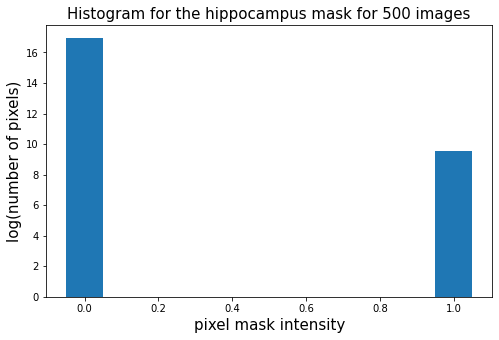

In [ ]:
training_array = np.ravel(training_array)
x,y = np.histogram(training_array)
logs = [np.log(x+1) for x in x] 
plt.figure(figsize=(8,5))
plt.bar(np.linspace(0,1,10), logs, width=0.1)
plt.xlabel('pixel mask intensity', fontsize=15) 
plt.ylabel('log(number of pixels)' , fontsize=15)
plt.title('Histogram for the hippocampus mask for 500 images' , fontsize=15)

From the histogram we see that the number of the background pixels is 6 orders of magnetides more than the hippocampus. The data is highly imbalanced.

### Preprocessing Images 


As we can see in the previous section, the label for the images are split in 2 parts: the left and right hyppocampus. For our purpose, we should have 1 label for every image. This label should be the total hyppocampus segmentation. Moreover, the final image should be 1 channel only, as the mask for the segmentation. This channel should be ones and zeros only.

#### 1- Convert Label images to Masks

  * Label Images are RBG Images, each channel with values from 0 to 255. 
  * Here we convert these images into a segmentation mask (binary images in 1 channel).

##### a) The segmentation Mask (1 Channel) without Thresholding

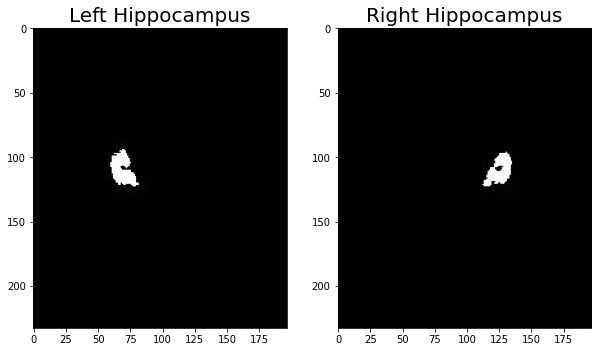

In [ ]:
im_left  = ImageOps.grayscale(Image.open(image_y_L))
im_right = ImageOps.grayscale(Image.open(image_y_R))
# Plot 
plt.figure(figsize = (10,7))
plt.subplot(1,2,1)
plt.title('Left Hippocampus',fontsize=20)
plt.imshow(im_left,cmap='gray')
plt.subplot(1,2,2)
plt.title('Right Hippocampus',fontsize=20)
plt.imshow(im_right,cmap='gray')

The image looks good but the values are all the way from 0 to 255

Text(0.5, 0, 'Pixel Intensity')

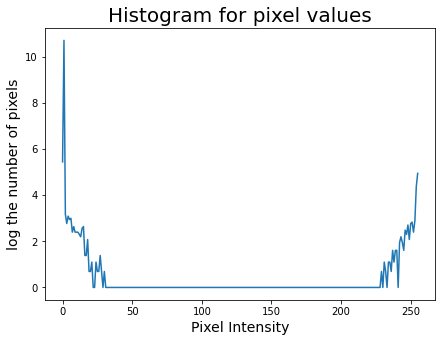

In [ ]:
x = [np.log(x+1) for x in im_left.histogram()]
plt.figure(figsize=(7,5))
plt.plot(x)
plt.title('Histogram for pixel values',fontsize=20)
plt.ylabel('log the number of pixels',fontsize=14)
plt.xlabel('Pixel Intensity',fontsize=14)


##### b) The segmentation Mask (1 Channel) with Thresholding

In [ ]:
def threshold(image):
  # Image is PIL Image
  # Converts the PIL Image into np array with the mask as ones and zeros
  image_threshold = np.array(image)
  image_threshold[image_threshold<=200] = 0
  image_threshold[image_threshold>200] = 1
  image_threshold = ImageOps.grayscale(Image.fromarray(image_threshold))
  return image_threshold

In [ ]:
im_right_threshold = threshold(im_right)
im_left_threshold  = threshold(im_left)

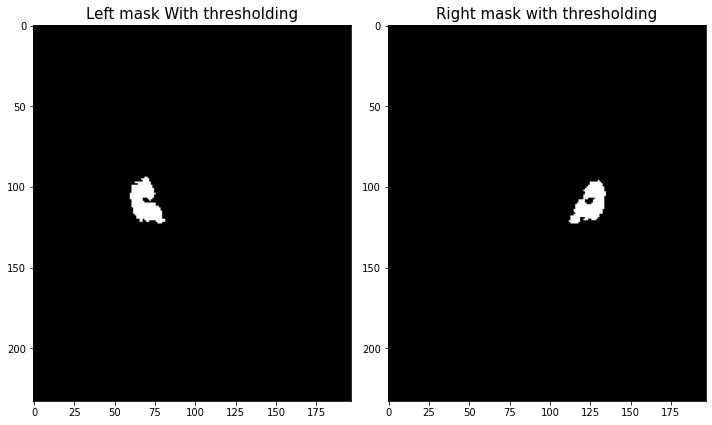

In [ ]:
# Plot 
fig = plt.figure(figsize = (10,10))

# Without thresholding
plt.subplot(121)
plt.title('Left mask With thresholding',fontsize=15)
plt.imshow(im_left_threshold,cmap='gray')
plt.subplot(122)
plt.title('Right mask with thresholding',fontsize=15)
plt.imshow(im_right_threshold, cmap='gray')

fig.tight_layout()

Let's look at the histogram

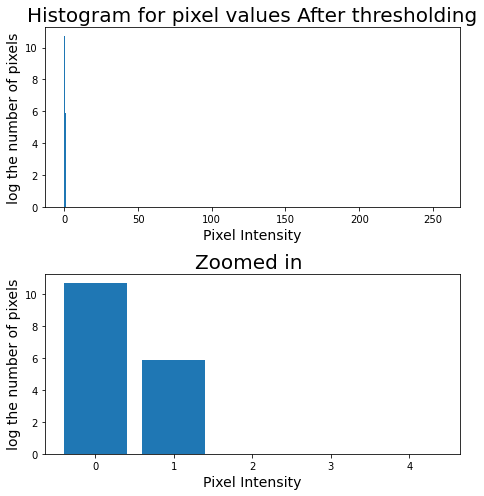

In [ ]:
x = [np.log(x+1) for x in im_left_threshold.histogram()]
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.bar(np.arange(len(x)),x)
plt.title('Histogram for pixel values After thresholding',fontsize=20)
plt.ylabel('log the number of pixels',fontsize=14)
plt.xlabel('Pixel Intensity',fontsize=14)
plt.subplot(212)
plt.bar(np.arange(5),x[:5])
plt.title('Zoomed in ',fontsize=20)
plt.ylabel('log the number of pixels',fontsize=14)
plt.xlabel('Pixel Intensity',fontsize=14)
plt.tight_layout()

#### 2- Combine the left and Right Hyppocampus Masks

In [ ]:
im_right_threshold = threshold(im_right)
im_left_threshold  = threshold(im_left)
total_hyppocampus  = np.array(im_right_threshold) + np.array(im_left_threshold)

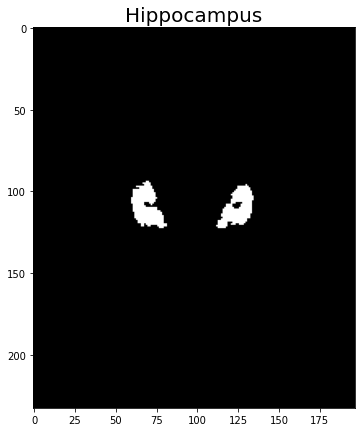

In [ ]:
plt.figure(figsize = (10,7))
plt.title('Hippocampus',fontsize=20)
plt.imshow(total_hyppocampus,cmap='gray')

#### 3- Create clean Data Folder

  * The data folder 'MRI' is split into strange file names and file structure.
  * The subject Ids are inconsistant between the images.
  * Some Images are curropted
  * Here we clean the data and organize the folder into x_train, y_train, x_test, y_test 

##### a) Encode subject IDs into simpler terms



In [ ]:
all_subjects  = [os.path.join(Data_folder, 'original','100',x) for x in  os.listdir(os.path.join(Data_folder, 'original','100'))]
all_subjects += [os.path.join(Data_folder, 'original','35', x) for x in  os.listdir(os.path.join(Data_folder, 'original','35'))]
all_subjects  = [x.split('/')[-1] for x in all_subjects if os.path.isdir(x)]
new_subjects  = [str(x) for x in np.arange(len(all_subjects))]
subjects_dict = {}
for x,y in zip(all_subjects,new_subjects ):
  subjects_dict[x] = y
subjects_dict

{'ADNI_002_S_0295_13722_ACPC': '76',
 'ADNI_002_S_0413_14437_ACPC': '28',
 'ADNI_002_S_0559_147119_ACPC': '25',
 'ADNI_002_S_0685_18211_tal_noscale': '128',
 'ADNI_002_S_0729_153075_ACPC': '88',
 'ADNI_002_S_0782_20519_ACPC': '10',
 'ADNI_002_S_0816_49010_ACPC': '15',
 'ADNI_002_S_0938_25952_ACPC': '60',
 'ADNI_002_S_0954_108600_ACPC': '13',
 'ADNI_002_S_1070_130146_ACPC': '103',
 'ADNI_002_S_1155_274154_ACPC': '116',
 'ADNI_002_S_1261_223901_ACPC': '132',
 'ADNI_002_S_1280_233435_ACPC': '129',
 'ADNI_002_S_4225_257270_ACPC': '99',
 'ADNI_003_S_0907_25737_ACPC': '12',
 'ADNI_003_S_0908_54988_ACPC': '21',
 'ADNI_003_S_0931_26236_ACPC': '5',
 'ADNI_003_S_1057_31613_ACPC': '62',
 'ADNI_003_S_1059_29252_ACPC': '8',
 'ADNI_003_S_1074_32035_tal_noscale': '102',
 'ADNI_003_S_1122_32044_ACPC': '27',
 'ADNI_003_S_1257_42137_ACPC': '18',
 'ADNI_003_S_4136_250173_ACPC': '61',
 'ADNI_003_S_4142_254893_ACPC': '86',
 'ADNI_005_S_0221_11604_tal_noscale': '125',
 'ADNI_005_S_0222_11299_ACPC': '20',
 '

##### b) Populate x_train and x_test directories


In [ ]:
# Create x_train and x_test directories
x_train_path = os.path.join(Data_folder, 'x_train')
if not os.path.isdir(x_train_path) :  os.mkdir(x_train_path)

x_test_path = os.path.join(Data_folder, 'x_test')
if not os.path.isdir(x_test_path) :  os.mkdir(x_test_path)

In [ ]:
# Populate x_train
original_dir = os.path.join(Data_folder, 'original','100')
old_train_dir = [os.path.join(original_dir,x) for x in  os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir,x))]
for subject in old_train_dir:
  encoded_subject_name = subjects_dict[subject.split('/')[-1]]
  print(encoded_subject_name)
  for old_image_name in os.listdir(subject):
    new_image_name = encoded_subject_name + '_' + old_image_name.split('_')[-1]
    new_image_path = os.path.join(x_train_path , new_image_name)
    old_image_path = os.path.join(subject,old_image_name)
    copyfile(old_image_path , new_image_path)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.06 µs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# Populate x_test
original_dir = os.path.join(Data_folder, 'original','35')
old_test_dir = [os.path.join(original_dir,x) for x in  os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir,x))]
for subject in old_test_dir:
  encoded_subject_name = subjects_dict[subject.split('/')[-1]]
  print(encoded_subject_name)
  for old_image_name in os.listdir(subject):
    new_image_name = encoded_subject_name + '_' + old_image_name.split('_')[-1]
    new_image_path = os.path.join(x_test_path , new_image_name)
    old_image_path = os.path.join(subject,old_image_name)
    copyfile(old_image_path , new_image_path)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


##### c) Populate y_train and y_test directories

In [ ]:
# Create y_train and y_test directories
y_train_path = os.path.join(Data_folder, 'y_train')
if not os.path.isdir(y_train_path) :  os.mkdir(y_train_path)

y_test_path = os.path.join(Data_folder, 'y_test')
if not os.path.isdir(y_test_path) :  os.mkdir(y_test_path)

In [ ]:
# Function to convert label images to the mask
def to_mask(subject_ID_dir , new_path):
  # Get left and right directories
  left_dir  = [os.path.join(subject_ID_dir,x) for x in os.listdir(subject_ID_dir) if 'L' in x][0]
  right_dir = [os.path.join(subject_ID_dir,x) for x in os.listdir(subject_ID_dir) if 'R' in x][0]
  # Get subject key encoded
  subject_id_in_labelDir = subject_ID_dir.split('/')[-1]
  subject_id_global = [x for x in subjects_dict.keys() if subject_id_in_labelDir  in x][0]
  encoded_subject_name = subjects_dict[subject_id_global]
  for old_image_name in os.listdir(left_dir):
    # Get the output image name 
    new_image_name = encoded_subject_name + '_' + old_image_name.split('_')[-1]
    new_image_name = os.path.join(new_path, new_image_name)
    # Get the left image
    left_image = Image.open(os.path.join(left_dir,old_image_name)).convert('L')
    # Get the right image
    try:
      right_image= Image.open(os.path.join(right_dir, old_image_name.replace('L','R'))).convert('L')
    except:
      # Some folders have different names between left and right images
      image_number = old_image_name.split('_')[-1]
      right_image_name = [os.path.join(right_dir,x) for x in os.listdir(right_dir) if image_number in x][0]
      right_image= Image.open(right_image_name).convert('L')
    # Threshold the images
    left_image_threshold   = threshold(left_image)
    right_image_threshold  = threshold(right_image)
    # Combine the images into 1 Hyppocampus
    total_hyppocampus  = left_image_threshold + right_image_threshold
    total_hyppocampus[total_hyppocampus > 1] = 1
    total_hyppocampus = total_hyppocampus.astype(np.uint8) 
    # Save the image
    total_hyppocampus = Image.fromarray(total_hyppocampus)
    total_hyppocampus.save(new_image_name.replace('jpg','png'))
  return 

In [ ]:
def check_if_processed(subject_ID, apath, all_subjects):
  # Returns True if the subject is already preprocessed, False otherwise 

  # Find all missing subject IDs 
  all_subjects_in_apath = (os.listdir(apath))
  all_subjects_in_apath = np.unique(np.array([int(x.split('_')[0]) for x in all_subjects_in_apath]))
  missing = np.setdiff1d(all_subjects,all_subjects_in_apath) 

  # Find the encoded value for the subject ID 
  try:
    encoded_id = int(subjects_dict[subject_ID])
  except:
    subject_id_global = [x for x in subjects_dict.keys() if subject_ID  in x][0]
    encoded_id = int(subjects_dict[subject_id_global])

  # check if missing
  if encoded_id in missing:
    return False 
  else:
    return True

In [ ]:
# Populate y_train
y_train_path_old = os.path.join(Data_folder,'label','100label')
i = 0
for subject_dir in os.listdir(y_train_path_old):
  subject_dir_full = os.path.join(y_train_path_old,subject_dir)
  if not os.path.isdir(subject_dir_full): continue
  i+=1
  print('Processing:', str(i),'%')
  if check_if_processed(subject_dir, y_train_path,all_subjects=np.arange(100)): continue
  try:
    to_mask(subject_dir_full, y_train_path)
  except Exception as e :
    print('subject:',subject_dir,'has error:',e)

Processing: 1 %
Processing: 2 %
Processing: 3 %
Processing: 4 %
Processing: 5 %
Processing: 6 %
Processing: 7 %
Processing: 8 %
Processing: 9 %
Processing: 10 %
Processing: 11 %
Processing: 12 %
Processing: 13 %
Processing: 14 %
Processing: 15 %
Processing: 16 %
Processing: 17 %
Processing: 18 %
Processing: 19 %
Processing: 20 %
Processing: 21 %
Processing: 22 %
Processing: 23 %
Processing: 24 %
Processing: 25 %
Processing: 26 %
Processing: 27 %
Processing: 28 %
Processing: 29 %
Processing: 30 %
Processing: 31 %
Processing: 32 %
Processing: 33 %
Processing: 34 %
Processing: 35 %
Processing: 36 %
Processing: 37 %
Processing: 38 %
Processing: 39 %
Processing: 40 %
Processing: 41 %
Processing: 42 %
Processing: 43 %
Processing: 44 %
Processing: 45 %
Processing: 46 %
Processing: 47 %
Processing: 48 %
Processing: 49 %
Processing: 50 %
Processing: 51 %
Processing: 52 %
Processing: 53 %
Processing: 54 %
Processing: 55 %
Processing: 56 %
Processing: 57 %
Processing: 58 %
Processing: 59 %
Proces

In [ ]:
# Populate y_test
y_test_path_old = os.path.join(Data_folder,'label','35label')
i = 0
for subject_dir in os.listdir(y_test_path_old):
  subject_dir_full = os.path.join(y_test_path_old,subject_dir)
  if not os.path.isdir(subject_dir_full): continue
  i+=1
  print('Processing:', int(i/35 * 100),'%')
  if check_if_processed(subject_dir, y_test_path,all_subjects=np.arange(100,135)): continue
  if not os.path.isdir(subject_dir_full): continue 
  try:
    to_mask(subject_dir_full, y_test_path)
  except Exception as e :
    print('subject:',subject_dir,'has error:',e)

Processing: 2 %
Processing: 5 %
Processing: 8 %
Processing: 11 %
Processing: 14 %
Processing: 17 %
Processing: 20 %
Processing: 22 %
Processing: 25 %
Processing: 28 %
Processing: 31 %
Processing: 34 %
Processing: 37 %
Processing: 40 %
Processing: 42 %
Processing: 45 %
Processing: 48 %
Processing: 51 %
Processing: 54 %
Processing: 57 %
Processing: 60 %
Processing: 62 %
Processing: 65 %
Processing: 68 %
Processing: 71 %
Processing: 74 %
Processing: 77 %
Processing: 80 %
Processing: 82 %
Processing: 85 %
Processing: 88 %
Processing: 91 %
Processing: 94 %
Processing: 97 %
Processing: 100 %


##### d) Final Check

  * Step 3 showed that "ADNI_013_S_0325_85153_ACPC" subject does not have the segmentations for the right hippocampus. 
  * Here we delete this subject from the dataset
  * and check total number of images in both the test set and training set

In [ ]:
bad_subject_id = subjects_dict['ADNI_013_S_0325_85153_ACPC'] + '_'
bad_images = [os.path.join(x_train_path,x) for x in os.listdir(x_train_path) if bad_subject_id in x]
for image in bad_images: os.remove(image)

In [ ]:
print('Number of training images =',len(os.listdir(x_train_path)))
print('Number of labels for training images =',len(os.listdir(y_train_path)))
print('Number of test images =',len(os.listdir(x_test_path)))
print('Number of labels for test images =',len(os.listdir(y_test_path)))

Number of training images = 18791
Number of labels for training images = 18711
Number of test images = 6673
Number of labels for test images = 6615


Something is wrong because the number of images and labels doesn't match!

In [ ]:
# Train
x_train_images = [x.split('.')[0] for x in os.listdir(x_train_path)]
y_train_images = [x.split('.')[0] for x in os.listdir(y_train_path)]
train_differences = np.setdiff1d(x_train_images,y_train_images)
# Test
x_test_images = [x.split('.')[0] for x in os.listdir(x_test_path)]
y_test_images = [x.split('.')[0] for x in os.listdir(y_test_path)]
test_differences = np.setdiff1d(x_test_images,y_test_images)
test_differences

array(['113_048 (1)', '113_049 (1)', '113_060 (1)', '113_074 (1)',
       '113_076 (1)', '113_100 (1)', '113_101 (1)', '113_102 (1)',
       '113_116 (1)', '113_128 (1)', '117_006 (1)', '117_007 (1)',
       '117_012 (1)', '117_013 (1)', '117_040 (1)', '117_041 (1)',
       '117_044 (1)', '117_045 (1)', '117_048 (1)', '117_050 (1)',
       '117_051 (1)', '117_054 (1)', '117_055 (1)', '117_060 (1)',
       '117_068 (1)', '117_069 (1)', '117_074 (1)', '117_078 (1)',
       '117_079 (1)', '117_082 (1)', '117_083 (1)', '117_086 (1)',
       '117_087 (1)', '117_092 (1)', '117_093 (1)', '117_096 (1)',
       '117_100 (1)', '117_104 (1)', '117_109 (1)', '117_110 (1)',
       '117_114 (1)', '117_118 (1)', '117_119 (1)', '117_121 (1)',
       '117_124 (1)', '117_125 (1)', '117_126 (1)', '117_130 (1)',
       '117_131 (1)', '117_132 (1)', '117_135 (1)', '117_138 (1)',
       '117_158 (1)', '117_164 (1)', '117_166 (1)', '117_170 (1)',
       '117_172 (1)', '117_173 (1)'], dtype='<U11')

In [ ]:
# Training Dataset
doublicates = [os.path.join(x_train_path,x)+'.jpg' for x in  np.setdiff1d(x_train_images,y_train_images)]
for d in doublicates:
  os.remove(d)

# Testing Dataset
doublicates = [os.path.join(x_test_path,x)+'.jpg' for x in  np.setdiff1d(x_test_images,y_test_images)]
for d in doublicates:
  os.remove(d)

Now one final check again! 

In [ ]:
print('Number of training images =',len(os.listdir(x_train_path)))
print('Number of labels for training images =',len(os.listdir(y_train_path)))
print('Number of test images =',len(os.listdir(x_test_path)))
print('Number of labels for test images =',len(os.listdir(y_test_path)))

print('')
print('Total number of images = ',len(os.listdir(x_train_path))+len(os.listdir(y_train_path)))

Number of training images = 18711
Number of labels for training images = 18711
Number of test images = 6615
Number of labels for test images = 6615

Total number of images =  37422


Perfect! We dropped only 1 subject. We have a total of 134 subjects, each one has 189 images. 

Now we are ready for deep learning! 

### Machine Learning 

#### Create Custom Dataset

In [ ]:
class MRI_dataset(Dataset):
  def __init__(self,root_dir, transform = None, train=False, test=False):

    if not train and not test:
      print('Error! You must choose train or test dataset!')
      return 

    self.transform = transform

    if train: 
      self.data_path  = os.path.join(root_dir,'x_train')
      self.label_path = os.path.join(root_dir,'y_train')
    
    if test:
      self.data_path  = os.path.join(root_dir,'x_test')
      self.label_path = os.path.join(root_dir,'y_test')

  def __len__(self):
    return len(os.listdir(self.data_path)) 

  def __getitem__(self,index):
      image_name = os.listdir(self.data_path)[index].split('.')[0]
      # Note: Data is in .jpg, label is on .png 
      image = os.path.join(self.data_path, image_name+'.jpg')
      label = os.path.join(self.label_path, image_name+'.png')

      image = ImageOps.grayscale(Image.open(image))
      label = ImageOps.grayscale(Image.open(label))

      if self.transform:
        image = self.transform(image)
        label = self.transform(label)
        # Transform will rescale image intensities to (0,1)
        # Make sure that the label is one after transform
        label[label!=0] = 1           
        # Note: Our implemtation make sure that the label has only zeros and ones
      return image,label

#### Load files, Transform and Dataloader

In [ ]:
batch_size = 32
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor()])

train_dataset= MRI_dataset(Data_folder, train=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,num_workers=2, shuffle=True)

In [ ]:
for x,y in train_loader:
  print(f'x = shape: {x.shape}; type: {x.dtype}')
  print(f'x = min: {x.min()}; max: {x.max()}')
  print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
  break


x = shape: torch.Size([32, 1, 128, 128]); type: torch.float32
x = min: 0.0; max: 0.9058823585510254
y = shape: torch.Size([32, 1, 128, 128]); class: tensor([0., 1.]); type: torch.float32


##### Visualize the images 

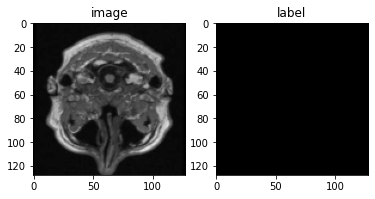

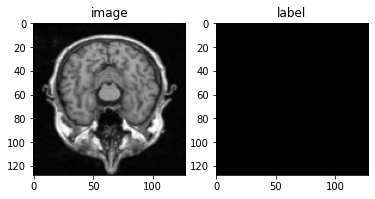

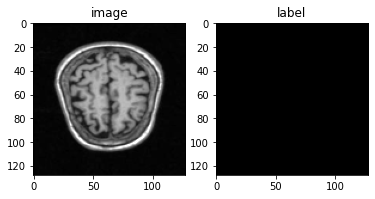

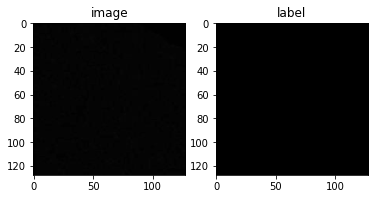

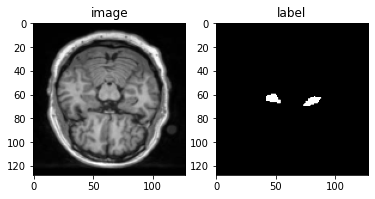

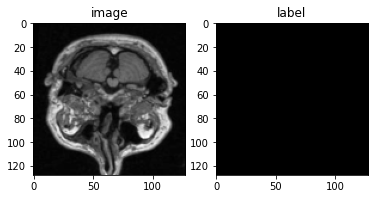

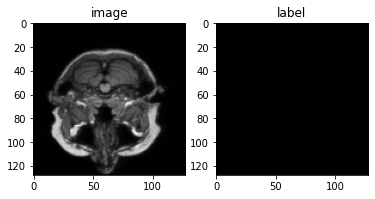

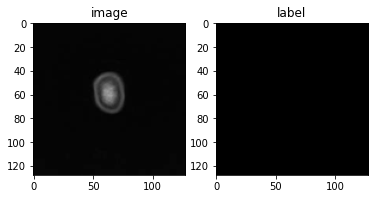

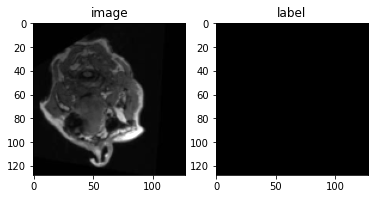

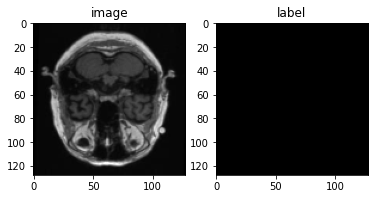

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [1, 74, 213, 224, 567, 779, 1052, 2000, 3000, 4444]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.subplot(121)
    plt.imshow(data[0,:,:], cmap='gray',vmin=0,vmax=0.7)
    plt.title('image')
    plt.subplot(122)
    plt.imshow(label[0,:,:],cmap='gray',vmin=0,vmax=0.7)
    plt.title('label')
    plt.show()

#### Train and Test Functions

In [ ]:
def train_model(model, optimizer, criterion, epochs=10, print_batch_metrics = False):
    model.train()
    model.to(device)

    loss_list, accuracy_list, recall_list = [], [], []
    for i in range(1,epochs+1):
      epoch_loss = []
      total,correct,batch_num = 0,0,1
      batch_loss, batch_acc, batch_recall = np.array([]), np.array([]),np.array([])
      for x,y in train_loader:
        x,y = x.to(device), y.to(device) # Put the image to the GPU if any
        y = y.squeeze(1)
        # Train
        optimizer.zero_grad()            # Reset the gradients 
        out = model(x)                   # Train the model
        out = out.squeeze(1)
        loss   = criterion(out, y)       # Binary Cross Entropy loss with logits
        loss.backward()                 # Calculate sgd wrt w 
        optimizer.step()                # Update the weights
        # Thresholding the logics to 1 and 0
        out[out < 0.5] = 0
        out[out >= 0.5] = 1
        # Calculate loss, accuraccy, and recall
        loss, acc, recall, b_correct, b_total = calculate_batch_metrics(y,out,loss)
        batch_loss   = np.append(batch_loss,loss)
        batch_acc    = np.append(batch_acc,acc)
        batch_recall = np.append(batch_recall,recall)
        epoch_loss.append(loss)
        correct += b_correct
        total   += b_total 
        if print_batch_metrics and batch_num % 10 == 0:
          print(' Batch_loss = ', round(np.mean(batch_loss),2),
                '   - Batch_recall = ',round(np.nanmean(batch_recall),2),
                '   - Batch_accuracy = ', round(np.mean(batch_acc),2))
          batch_loss, batch_acc, batch_recall = np.array([]), np.array([]),np.array([])
        batch_num +=1
      # Epoch calculations
      epoch_loss = sum(epoch_loss) / len(epoch_loss)
      epoch_acc  = correct / total 

      # Save metrics
      loss_list.append(epoch_loss) 
      accuracy_list.append(epoch_acc)
      recall_list.append(epoch_recall)
      print('Epoch:'    ,i,
            ' - Loss:', round(epoch_loss,2),
            ' - Accuracy:', round(epoch_acc,2),
            ' - Recall:', round(epoch_recall,2))          
    return loss_list, accuracy_list, recall_list

#### Other functions

In [ ]:
def calculate_batch_metrics(y,out,loss):
  # Calculate loss, accuraccy, and recall
  loss    = loss.item()
  correct = (out==y).sum().item()
  total   = len(y.ravel())

  number_of_ones = y.sum().item()     
  correct_predictions_ones = ((y==1) * (out==1)).sum().item()
  
  acc = correct / total * 100
  recall = np.nan 
  if number_of_ones !=0: 
    recall = correct_predictions_ones / number_of_ones

  return loss, acc, recall, correct, total

#### Create a Model

In [ ]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1 , out_channels=16 , kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32 , kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16 , kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=1  , kernel_size=3,padding=1)

    def forward(self, x):
      x = torch.relu(self.conv1(x)) 
      x = torch.relu(self.conv2(x))
      x = torch.max_pool2d(x, (2,2))
      x = torch.relu(self.conv3(x))
      x = F.interpolate(x, scale_factor=2)
      x = self.conv4(x)
      return x

In [ ]:
model = FCNN()

#### Create Criterion and Optimizer 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

#### Train the Model

In [ ]:
start_time = time.time()
loss,accuracy, recall = train_model(model, optimizer, criterion, epochs=1, print_batch_metrics=True)
print('Took: ', (time.time()-start_time)/60, 'minutes' )

Batch_loss =  0.61    - Batch_recall =  0.0
Batch_loss =  0.6    - Batch_recall =  0.0
Batch_loss =  0.6    - Batch_recall =  0.0
Batch_loss =  0.6    - Batch_recall =  0.0
Batch_loss =  0.59    - Batch_recall =  0.0
Batch_loss =  0.59    - Batch_recall =  0.0
Batch_loss =  0.59    - Batch_recall =  0.0
Batch_loss =  0.59    - Batch_recall =  0.0
Batch_loss =  0.58    - Batch_recall =  0.0
Batch_loss =  0.57    - Batch_recall =  0.0
Batch_loss =  0.57    - Batch_recall =  0.0
Batch_loss =  0.57    - Batch_recall =  0.0
Batch_loss =  0.56    - Batch_recall =  0.0
Batch_loss =  0.56    - Batch_recall =  0.0
Batch_loss =  0.56    - Batch_recall =  0.0
Batch_loss =  0.55    - Batch_recall =  0.0
Batch_loss =  0.54    - Batch_recall =  0.0
Batch_loss =  0.54    - Batch_recall =  0.0
Batch_loss =  0.53    - Batch_recall =  0.0
Batch_loss =  0.53    - Batch_recall =  0.0
Batch_loss =  0.52    - Batch_recall =  0.0
Batch_loss =  0.52    - Batch_recall =  0.0
Batch_loss =  0.51    - Batch_recal

#### U-Net

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [ ]:
start_time = time.time()
loss,accuracy, recall = train_model(model, optimizer, criterion, epochs=1, print_batch_metrics=True)
print('Took: ', (time.time()-start_time)/60, 'minutes' )

In [ ]:
 '''
 Batch_loss =  0.97    - Batch_recall =  0.49    - Batch_accuracy =  69.25
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  69.44
 Batch_loss =  0.97    - Batch_recall =  0.49    - Batch_accuracy =  70.27
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  69.38
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  69.27
 Batch_loss =  0.97    - Batch_recall =  0.54    - Batch_accuracy =  70.48
 Batch_loss =  0.97    - Batch_recall =  0.53    - Batch_accuracy =  68.82
 Batch_loss =  0.97    - Batch_recall =  0.54    - Batch_accuracy =  68.61
 Batch_loss =  0.97    - Batch_recall =  0.48    - Batch_accuracy =  69.12
 Batch_loss =  0.97    - Batch_recall =  0.55    - Batch_accuracy =  69.41
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  68.87
 Batch_loss =  0.97    - Batch_recall =  0.54    - Batch_accuracy =  70.07
 Batch_loss =  0.97    - Batch_recall =  0.47    - Batch_accuracy =  70.27
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  69.21
 Batch_loss =  0.97    - Batch_recall =  0.57    - Batch_accuracy =  68.91
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  67.72
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  67.63
 Batch_loss =  0.97    - Batch_recall =  0.54    - Batch_accuracy =  68.67
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  69.4
 Batch_loss =  0.97    - Batch_recall =  0.45    - Batch_accuracy =  69.31
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  68.35
 Batch_loss =  0.97    - Batch_recall =  0.48    - Batch_accuracy =  68.85
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  69.03
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  70.12
 Batch_loss =  0.97    - Batch_recall =  0.48    - Batch_accuracy =  68.99
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  68.44
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  69.49
 Batch_loss =  0.97    - Batch_recall =  0.53    - Batch_accuracy =  69.34
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  68.97
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  68.68
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  69.81
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  68.69
 Batch_loss =  0.97    - Batch_recall =  0.47    - Batch_accuracy =  68.95
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  70.32
 Batch_loss =  0.97    - Batch_recall =  0.55    - Batch_accuracy =  69.17
 Batch_loss =  0.97    - Batch_recall =  0.46    - Batch_accuracy =  70.78
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  70.12
 Batch_loss =  0.97    - Batch_recall =  0.53    - Batch_accuracy =  69.95
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  70.29
 Batch_loss =  0.97    - Batch_recall =  0.54    - Batch_accuracy =  69.65
 Batch_loss =  0.97    - Batch_recall =  0.46    - Batch_accuracy =  68.82
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  70.13
 Batch_loss =  0.97    - Batch_recall =  0.49    - Batch_accuracy =  69.74
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  68.69
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  69.38
 Batch_loss =  0.97    - Batch_recall =  0.54    - Batch_accuracy =  69.49
 Batch_loss =  0.97    - Batch_recall =  0.49    - Batch_accuracy =  70.2
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  68.47
 Batch_loss =  0.97    - Batch_recall =  0.48    - Batch_accuracy =  69.32
 Batch_loss =  0.97    - Batch_recall =  0.51    - Batch_accuracy =  70.91
 Batch_loss =  0.97    - Batch_recall =  0.48    - Batch_accuracy =  69.41
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  69.05
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  68.16
 Batch_loss =  0.97    - Batch_recall =  0.44    - Batch_accuracy =  69.48
 Batch_loss =  0.97    - Batch_recall =  0.52    - Batch_accuracy =  68.88
 Batch_loss =  0.97    - Batch_recall =  0.5    - Batch_accuracy =  69.28
 Batch_loss =  0.97    - Batch_recall =  0.53    - Batch_accuracy =  69.33
 Batch_loss =  0.97    - Batch_recall =  0.49    - Batch_accuracy =  68.84
 '''

## Conclusion

For our final project, we explored the use of various neural network models for semantic segmentation of medical images of the lungs and hippocampus. For both the lungs and hippocampus, we were interested in the exact same task: obtain a mask capturing the entire relevant tissue, but upon training and testing of both datasets we soon found out the same model can have wildly different performance for the same task.

The hippocampus dataset was marred by class imbalance across the 2D image cross-sections of the brain because the hippocampus only covers a small volume of the brain MRI volume for each patient. Furthermore, the contrast between the hippocampus and the other brain tissues is very bad. On the other hand, the lungs dataset was better balanced because the lungs cover a larger volume of the chest CT volume. Importantly, the lungs are clearly separated from the bones and other tissue due to being filled with air, while the hippocampus is naturally more "hidden" across the flatter intensity gradations of brain tissue. Given these physiological and MRI and CT image differences, we found that our best model, U-Net, performed extremely well on the lungs CT dataset but poorly on the hippocampus MRI dataset. The models could be further improved using hyperparamter tuning methods and cross validations, but the performace on the lung dataset was excellent with the initial hyperparameters. The hippocampus case is much more difficult because of the model selection and class imbalance. 

Future work for semantic segmentation of medical images of the lungs and hippocampus can run in multiple directions. For the lungs, multiplex segmentation of various tissue compartments would be of great clinical interest -- for example, blood vessels, airways, and injured lungs where no air is flowing into the lungs (COPD and emphasyma). For the hippocampus, improving semantic segmentation may be possible by using V-Net architectures which can take into the account the 3D structure of the brain and potentially be more resilient to class imbalance. A motivation behind improving hippocampus semantic segmentation methods is the possibility of accurately tracking hippocampus volume over the course of neurological diseases, particularly Alzheimer's and other types of dementia. 

## References


* **U-Net implementation**
  * https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
* **FCN-ResNet101 implementation**
  * https://pytorch.org/hub/pytorch_vision_fcn_resnet101/
  * https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html